## Project I: Deep Autoencoder based on Dense Neural Networks over MNIST and FMNIST databases
### Authors: Daniel Toribio, Alejo González, Andrés Navarro

#### 1.- MNIST and FMINST datasets

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [ ]:
#!pip install wandb
import wandb # Weight & Biases library to monitor training and compare models
wandb.login() # API key: 

Select Data Set and Projected Dimensions: 

In [3]:
INDEX = 0 # INDEX = 0 for MNIST and 1 for FMNIST!
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into


Functions Definition in order to Train, Save, Load and Evaluate the models

In [4]:
def train_models(projected_dimensions, autoencoder, epochs, train_set, valid_set, INDEX):
    models_autoencoder = []
    for i in range(len(projected_dimensions)):
        model = autoencoder(projected_dimensions[i], INDEX)  # To initialize the model with the projected dimension
        model.do_training(epochs, train_set[INDEX], valid_set[INDEX])
        models_autoencoder.append(model)
    return models_autoencoder
            
def save_models(projected_dimensions, models_autoencoder3, models_autoencoder5, INDEX):
    if INDEX == 0:  # MNIST
        for i in range(len(models_autoencoder3)):
            torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_MNIST_{projected_dimensions[i]}.pth')
            torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_MNIST_{projected_dimensions[i]}.pth')
    elif INDEX == 1:  # FMNIST
        for i in range(len(models_autoencoder3)):
            torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_FMNIST_{projected_dimensions[i]}.pth')
            torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_FMNIST_{projected_dimensions[i]}.pth')
    else:
        raise ValueError("While saving the models, INDEX should be either 0 or 1.")

def load_models(projected_dimensions, autoencoder3, autoencoder5, models_autoencoder3, models_autoencoder5, INDEX):
    if INDEX == 0:  # MNIST
        dataset0 = "MNIST"
    else:
        dataset0 = "FMNIST"

    for i in range(len(projected_dimensions)):
        state_dict_3 = torch.load(f'model_autoencoder3_{dataset0}_{projected_dimensions[i]}.pth')
        model_3 = autoencoder3(projected_dimensions[i], INDEX)  # Assuming autoencoder3 is defined elsewhere
        model_3.load_state_dict(state_dict_3)
        models_autoencoder3.append(model_3)

        state_dict_5 = torch.load(f'model_autoencoder5_{dataset0}_{projected_dimensions[i]}.pth')
        model_5 = autoencoder5(projected_dimensions[i], INDEX)  # Assuming autoencoder5 is defined elsewhere
        model_5.load_state_dict(state_dict_5)
        models_autoencoder5.append(model_5)

def evaluate_models(models, train, valid, test):
    for n_layers in range(len(models)):
        for i, model in enumerate(models[n_layers]):
            n_lay = 3 if n_layers == 0 else 5
            print(f"Autoenc{n_lay}, train-{projected_dimensions[i]}. Projections:", model.eval_performance(train))
            print(f"Autoenc{n_lay}, val-{projected_dimensions[i]}. Projections:", model.eval_performance(valid))
            print(f"Autoenc{n_lay}, test-{projected_dimensions[i]}. Projections:", model.eval_performance(test), "\n")

To obtain the MNIST dataset:

In [5]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_MNIST = torch.utils.data.DataLoader(trainsetMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_MNIST = torch.utils.data.DataLoader(testsetMNIST, batch_size=64, shuffle=True)

To obtain the FMINST dataset:

In [6]:

# Download and load the training data
trainsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_FMNIST = torch.utils.data.DataLoader(trainsetFMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_FMNIST = torch.utils.data.DataLoader(testsetFMNIST, batch_size=64, shuffle=True)

In [7]:
dataiter = iter(train_MNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


In [8]:
dataiter = iter(train_FMNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


We can see that our images are of size 28 x 28 = 784, so the input layer is of size 784. It is important to see that the range of the values are -1,1 so for the output layer we will use the tanh.

We also need to split the training data into training and validation sets.

Load MNIST Data Set

In [9]:
import copy

valid_MNIST = copy.deepcopy(train_MNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_MNIST.dataset.data = train_MNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_MNIST.dataset.data = valid_MNIST.dataset.data[45000:,:,:]


Load FMNIST Data Set

In [10]:
import copy

valid_FMNIST = copy.deepcopy(train_FMNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_FMNIST.dataset.data = train_FMNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_FMNIST.dataset.data = valid_FMNIST.dataset.data[45000:,:,:]

Select Data Set To Be Trained:

In [11]:
train_set = [train_MNIST, train_FMNIST]
valid_set = [valid_MNIST, valid_FMNIST]
test_set =  [test_MNIST, test_FMNIST]

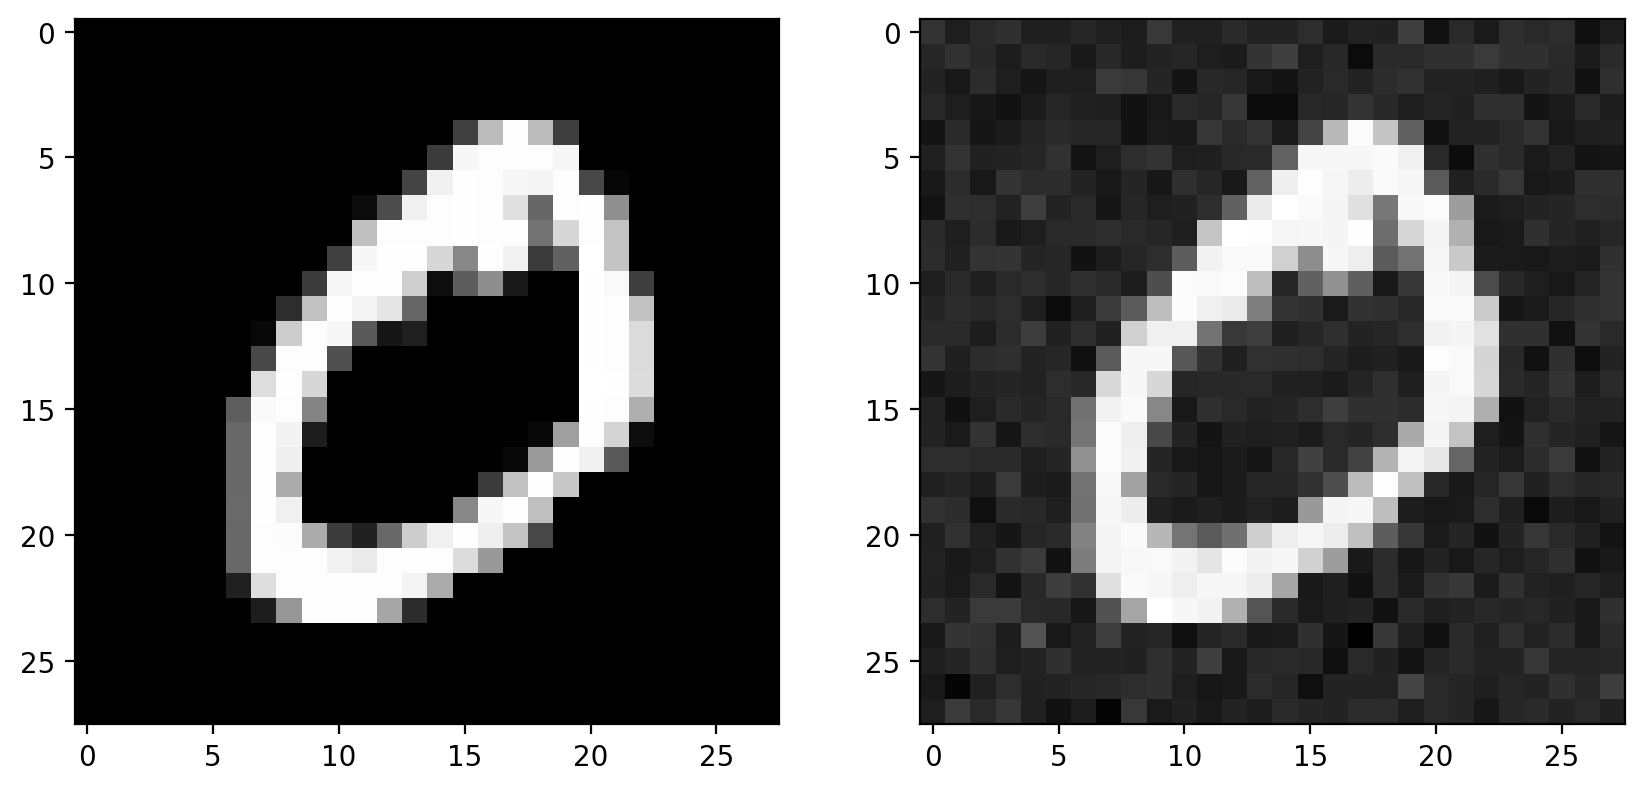

In [12]:
def add_noise(img, variance):
    noise = np.random.normal(loc=0, scale=np.sqrt(variance), size=img.shape)
    noisy_img = img + noise
    return noisy_img

img = train_set[INDEX].dataset.data[1,:,:]
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.imshow(add_noise(img,100).numpy().reshape([28,28]), cmap='Greys_r')


## 3 layers at both encoder/decoder:


In [13]:

class autoencoder3(nn.Module):
    def __init__(self, projected_dimension, INDEX):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.INDEX = INDEX


        if self.INDEX == 0:  # MNIST
            self.name_train = f"3_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif self.INDEX == 1:  # FMNIST
            self.name_train = f"3_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder3, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2), # Dropout with a probability of 0.2
            nn.Linear(300, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, self.projected_dimension),
            nn.ReLU(),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, self.input_image_size),
            nn.Tanh(),
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # here training starts
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img_noised = add_noise(img,4)
                img = img.reshape(-1, self.input_image_size)
                img_noised = img_noised.reshape(-1, self.input_image_size)
                enco,reconstructed = self.forward(img_noised.float())

                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    img_noised = add_noise(images,4)
                    img_noised = img_noised.reshape(-1, self.input_image_size)
                    images = images.reshape(-1, self.input_image_size)
                    encod,reconstruct = self.forward(img_noised.float())

                    loss_valid = self.criterion(reconstruct,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": self.projected_dimension, "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((self.projected_dimension, epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              _,reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

Definition of parameters of the model and Peak signal-to-noise ratio (PSNR)

Training the model

In [14]:
epochs = 30
models_autoencoder3 = train_models(projected_dimensions, autoencoder3, epochs, train_set, valid_set, INDEX)

Epoch:  1 Loss train:  0.20001330004412343 , Loss valid:  0.16371931167359047
Epoch:  2 Loss train:  0.15244184895841914 , Loss valid:  0.1449428531717747
Epoch:  3 Loss train:  0.14018940350929784 , Loss valid:  0.13806260605441764
Epoch:  4 Loss train:  0.1341771707150408 , Loss valid:  0.13331976488549657
Epoch:  5 Loss train:  0.1298899388427592 , Loss valid:  0.1285543940802838
Epoch:  6 Loss train:  0.12699497951490973 , Loss valid:  0.12675594655757255
Epoch:  7 Loss train:  0.12486435239076275 , Loss valid:  0.1256902818350082
Epoch:  8 Loss train:  0.12313440451610157 , Loss valid:  0.12427969914167486
Epoch:  9 Loss train:  0.1216116338566115 , Loss valid:  0.12179922138122802
Epoch:  10 Loss train:  0.12056935529901901 , Loss valid:  0.12156765996775729
Epoch:  11 Loss train:  0.11953415036921135 , Loss valid:  0.12010420732041623
Epoch:  12 Loss train:  0.11883149610366672 , Loss valid:  0.11985841032038344
Epoch:  13 Loss train:  0.11809993570204824 , Loss valid:  0.119676

Loss train,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.11295
Loss valid,0.11505
projected dimension,15


Epoch:  1 Loss train:  0.19223724750124596 , Loss valid:  0.14985626492094486
Epoch:  2 Loss train:  0.1408235250908712 , Loss valid:  0.13715682930134712
Epoch:  3 Loss train:  0.13128729715985668 , Loss valid:  0.1284426137804985
Epoch:  4 Loss train:  0.1259601506171748 , Loss valid:  0.12497437992628585
Epoch:  5 Loss train:  0.1220891281475567 , Loss valid:  0.12113151138133191
Epoch:  6 Loss train:  0.11972357954999263 , Loss valid:  0.12091961950063705
Epoch:  7 Loss train:  0.11766990352506665 , Loss valid:  0.1178475891339018
Epoch:  8 Loss train:  0.11620102341244505 , Loss valid:  0.11699461027028712
Epoch:  9 Loss train:  0.11510771812490103 , Loss valid:  0.11544460001144004
Epoch:  10 Loss train:  0.1140230434459888 , Loss valid:  0.11568247992941674
Epoch:  11 Loss train:  0.11344355552203277 , Loss valid:  0.11352283707324495
Epoch:  12 Loss train:  0.11203820755789903 , Loss valid:  0.11471289253615319
Epoch:  13 Loss train:  0.11210979604881934 , Loss valid:  0.113670

Loss train,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.10689
Loss valid,0.10844
projected dimension,30


Epoch:  1 Loss train:  0.19302685095251285 , Loss valid:  0.1499732623074917
Epoch:  2 Loss train:  0.14027295453177596 , Loss valid:  0.1349205214926537
Epoch:  3 Loss train:  0.13017861697484145 , Loss valid:  0.12707049028670533
Epoch:  4 Loss train:  0.12452262540517206 , Loss valid:  0.12353055229846467
Epoch:  5 Loss train:  0.12081178108399565 , Loss valid:  0.122136364243132
Epoch:  6 Loss train:  0.1177649893797934 , Loss valid:  0.11796149180290547
Epoch:  7 Loss train:  0.1155616397630762 , Loss valid:  0.11604760003850816
Epoch:  8 Loss train:  0.1141600331228057 , Loss valid:  0.11493789937267912
Epoch:  9 Loss train:  0.11335684619420631 , Loss valid:  0.11381113218500259
Epoch:  10 Loss train:  0.11192772231615064 , Loss valid:  0.11263219739528413
Epoch:  11 Loss train:  0.11103603202553297 , Loss valid:  0.1125586006552615
Epoch:  12 Loss train:  0.11034311347810383 , Loss valid:  0.11165099185197912
Epoch:  13 Loss train:  0.10975487547164614 , Loss valid:  0.11334994

Loss train,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.10468
Loss valid,0.108
projected dimension,50


Epoch:  1 Loss train:  0.18940747789615256 , Loss valid:  0.14752592545874577
Epoch:  2 Loss train:  0.1388757377439602 , Loss valid:  0.13526356524609504
Epoch:  3 Loss train:  0.12895559972490778 , Loss valid:  0.12859679764889656
Epoch:  4 Loss train:  0.12373715379825709 , Loss valid:  0.12332841728595977
Epoch:  5 Loss train:  0.12000093497970904 , Loss valid:  0.12016017998152591
Epoch:  6 Loss train:  0.1171501459215175 , Loss valid:  0.11863032611126595
Epoch:  7 Loss train:  0.11527692901224575 , Loss valid:  0.11573278285721515
Epoch:  8 Loss train:  0.11392663713459941 , Loss valid:  0.11512730013816914
Epoch:  9 Loss train:  0.11283069347370077 , Loss valid:  0.11376436619048423
Epoch:  10 Loss train:  0.11139806182208387 , Loss valid:  0.11273242698070851
Epoch:  11 Loss train:  0.11062496322715147 , Loss valid:  0.11240835877809119
Epoch:  12 Loss train:  0.10986416235523806 , Loss valid:  0.11178433568553722
Epoch:  13 Loss train:  0.10965442920992659 , Loss valid:  0.11

Loss train,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.10427
Loss valid,0.1062
projected dimension,100


Visualization of reconstructed images

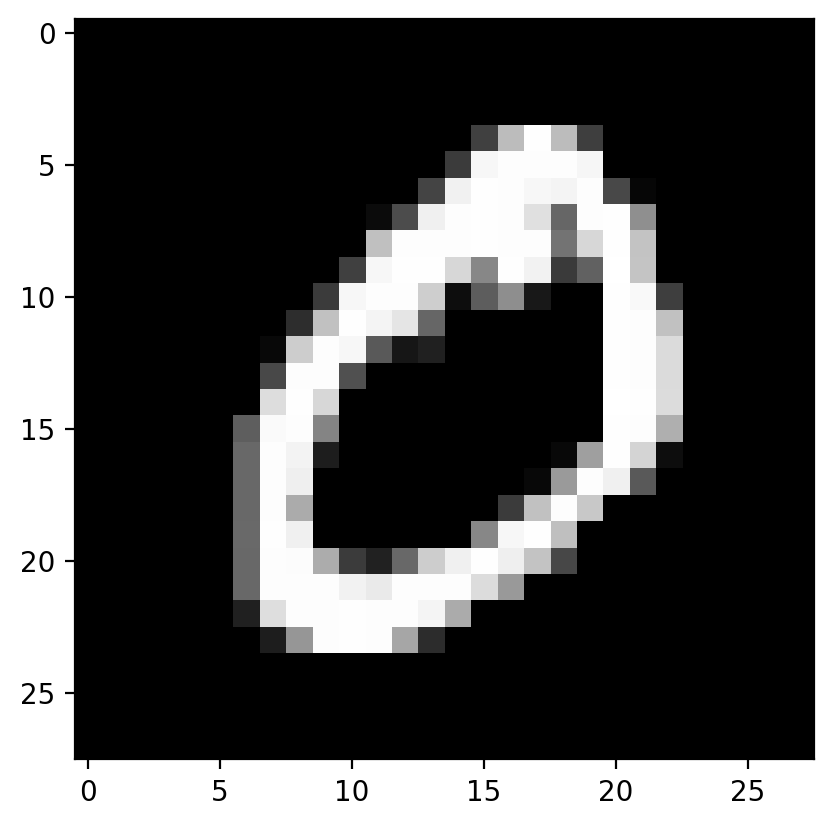

In [15]:
img = train_set[INDEX].dataset.data[1,:,:]
noised_img = add_noise(img, 100)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')

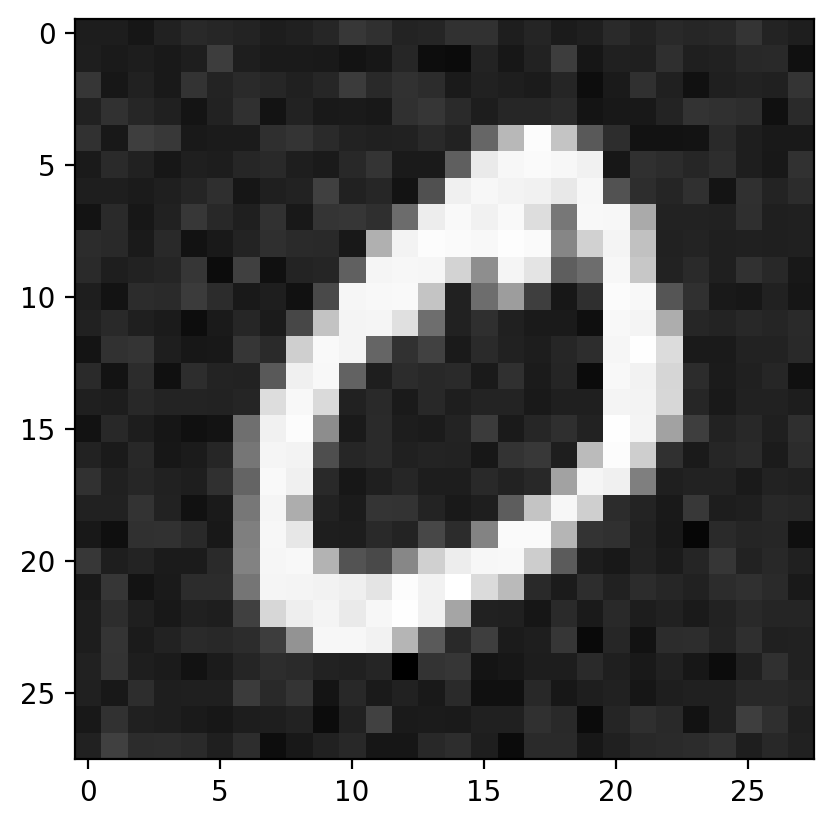

In [16]:
plt.imshow(noised_img.numpy().reshape([28,28]), cmap='Greys_r')

In [ ]:
noised_img = noised_img.reshape(-1, 784)
reconstructed = models_autoencoder3[-1].forward(noised_img.float())
plt.imshow(reconstructed.detach().numpy().reshape([28,28]))

# 5 layers at both encoder/decoder:

In [18]:
class autoencoder5(nn.Module):
    def __init__(self,projected_dimension, INDEX):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.INDEX = INDEX
        
        if self.INDEX == 0:  # MNIST
            self.name_train = f"5_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif self.INDEX == 1:  # FMNIST
            self.name_train = f"5_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder5, INDEX should be either 0 or 1.")


        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(784, 550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300,200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200,projected_dimension),
            nn.ReLU()
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(projected_dimension, 200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400,550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550,784),
            nn.Tanh()
        )

        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()


        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                reconstructed = self.forward(img)
                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    out = self.forward(images)

                    loss_valid = self.criterion(out,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": self.projected_dimension, "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((self.projected_dimension, epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

In [19]:
epochs = 30
models_autoencoder5 = train_models(projected_dimensions, autoencoder5, epochs, train_set, valid_set, INDEX)

Epoch:  1 Loss train:  0.19373067047192968 , Loss valid:  0.13507718548495717
Epoch:  2 Loss train:  0.11510168782181361 , Loss valid:  0.1043956348236571
Epoch:  3 Loss train:  0.0946384854932231 , Loss valid:  0.09078150030146254
Epoch:  4 Loss train:  0.08626200360330669 , Loss valid:  0.08500740800766235
Epoch:  5 Loss train:  0.0813688595821573 , Loss valid:  0.08299665070594625
Epoch:  6 Loss train:  0.07736791485116225 , Loss valid:  0.07880265980641893
Epoch:  7 Loss train:  0.07378451372708449 , Loss valid:  0.07613802874024878
Epoch:  8 Loss train:  0.07000945131717758 , Loss valid:  0.07298653801070883
Epoch:  9 Loss train:  0.06657831579319794 , Loss valid:  0.0692792813036036
Epoch:  10 Loss train:  0.064388202550948 , Loss valid:  0.06894466667733294
Epoch:  11 Loss train:  0.06221546336944977 , Loss valid:  0.06712838760081757
Epoch:  12 Loss train:  0.06089124596804719 , Loss valid:  0.06690561222903271
Epoch:  13 Loss train:  0.05935981989287856 , Loss valid:  0.064058

Loss train,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04849
Loss valid,0.05657
projected dimension,15


Epoch:  1 Loss train:  0.19331959650894118 , Loss valid:  0.12950052666537304
Epoch:  2 Loss train:  0.1124592632880773 , Loss valid:  0.10440985991599712
Epoch:  3 Loss train:  0.09420260032427243 , Loss valid:  0.09495065186886077
Epoch:  4 Loss train:  0.0857709998222576 , Loss valid:  0.08699445768873743
Epoch:  5 Loss train:  0.08087667060846632 , Loss valid:  0.0824338101960243
Epoch:  6 Loss train:  0.0774743570046584 , Loss valid:  0.07929801392428418
Epoch:  7 Loss train:  0.07501597682924264 , Loss valid:  0.08096755219900861
Epoch:  8 Loss train:  0.07245476516387002 , Loss valid:  0.07665162330612223
Epoch:  9 Loss train:  0.06987331532979045 , Loss valid:  0.07384721448129795
Epoch:  10 Loss train:  0.06708309883040121 , Loss valid:  0.07119158565046939
Epoch:  11 Loss train:  0.06411956634838134 , Loss valid:  0.06842328276722989
Epoch:  12 Loss train:  0.06187540250936185 , Loss valid:  0.06591740122183841
Epoch:  13 Loss train:  0.06010386731941253 , Loss valid:  0.0640

Loss train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04356
Loss valid,0.0521
projected dimension,30


Epoch:  1 Loss train:  0.1979117696173489 , Loss valid:  0.13484925646731194
Epoch:  2 Loss train:  0.11536254771900448 , Loss valid:  0.10654816066331052
Epoch:  3 Loss train:  0.09825000745794651 , Loss valid:  0.0962404896604254
Epoch:  4 Loss train:  0.08782025110188195 , Loss valid:  0.0878013200582342
Epoch:  5 Loss train:  0.08184815223582766 , Loss valid:  0.08301020718001305
Epoch:  6 Loss train:  0.07818037436597726 , Loss valid:  0.07955966017981793
Epoch:  7 Loss train:  0.0750107114541937 , Loss valid:  0.07964788922604094
Epoch:  8 Loss train:  0.07172955047677863 , Loss valid:  0.07395130402230202
Epoch:  9 Loss train:  0.0685232116798447 , Loss valid:  0.07092307135462761
Epoch:  10 Loss train:  0.065634967002552 , Loss valid:  0.06834127021596786
Epoch:  11 Loss train:  0.06351752689806744 , Loss valid:  0.06654425068421567
Epoch:  12 Loss train:  0.06167585170425644 , Loss valid:  0.06741996930634722
Epoch:  13 Loss train:  0.059982924050101166 , Loss valid:  0.064582

Loss train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04352
Loss valid,0.05173
projected dimension,50


Epoch:  1 Loss train:  0.200150233799253 , Loss valid:  0.13838610284506006
Epoch:  2 Loss train:  0.1190869363278828 , Loss valid:  0.10765700498793987
Epoch:  3 Loss train:  0.0978816286872395 , Loss valid:  0.09464903825775106
Epoch:  4 Loss train:  0.0879929919346151 , Loss valid:  0.0877997117473724
Epoch:  5 Loss train:  0.08283818643328479 , Loss valid:  0.08396253141951053
Epoch:  6 Loss train:  0.07952146080788225 , Loss valid:  0.08172802817314229
Epoch:  7 Loss train:  0.07662967810491947 , Loss valid:  0.07971048548500588
Epoch:  8 Loss train:  0.07458040810888633 , Loss valid:  0.07788539931495139
Epoch:  9 Loss train:  0.07261547608174045 , Loss valid:  0.07552319365613004
Epoch:  10 Loss train:  0.07091351978438483 , Loss valid:  0.07585245478660502
Epoch:  11 Loss train:  0.06933775901349938 , Loss valid:  0.0726099413601642
Epoch:  12 Loss train:  0.06760589067231525 , Loss valid:  0.07344618141651153
Epoch:  13 Loss train:  0.06601661910429936 , Loss valid:  0.0720675

Loss train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04662
Loss valid,0.05726
projected dimension,100


### Save the models

In [20]:
save_models(projected_dimensions, models_autoencoder3, models_autoencoder5, INDEX)

### Load the models

In [21]:
models_autoencoder3 = []
models_autoencoder5 = []
load_models(projected_dimensions, autoencoder3, autoencoder5, models_autoencoder3, models_autoencoder5, INDEX)

### Evaluation of the performance of the models without regularization

In [22]:
models = [models_autoencoder3, models_autoencoder5]
evaluate_models(models, train_set[INDEX], valid_set[INDEX], test_set[INDEX]) 

Autoenc3, train-15. Projections: tensor(10.2761)
Autoenc3, val-15. Projections: tensor(10.8408)
Autoenc3, test-15. Projections: tensor(11.0808) 

Autoenc3, train-30. Projections: tensor(11.9150)
Autoenc3, val-30. Projections: tensor(11.3848)
Autoenc3, test-30. Projections: tensor(11.7351) 

Autoenc3, train-50. Projections: tensor(11.3367)
Autoenc3, val-50. Projections: tensor(11.0231)
Autoenc3, test-50. Projections: tensor(11.3568) 

Autoenc3, train-100. Projections: tensor(11.9843)
Autoenc3, val-100. Projections: tensor(10.9808)
Autoenc3, test-100. Projections: tensor(11.6429) 

Autoenc5, train-15. Projections: tensor(12.9971)
Autoenc5, val-15. Projections: tensor(12.1647)
Autoenc5, test-15. Projections: tensor(13.8004) 

Autoenc5, train-30. Projections: tensor(12.9160)
Autoenc5, val-30. Projections: tensor(12.6693)
Autoenc5, test-30. Projections: tensor(12.6603) 

Autoenc5, train-50. Projections: tensor(14.2898)
Autoenc5, val-50. Projections: tensor(12.9193)
Autoenc5, test-50. Projec

After analysing the losses of the train and validation sets we can see that we can apply early stopping in 15 epochs because the validation loss is getting small slowly after that point.

## Training the models with early stopping, dropout and Lasso regularization

### Autoencoder with 3 Layers and Regularization

In [23]:

class autoencoder3_regularized(nn.Module):
    def __init__(self, projected_dimension, INDEX):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.lambd = 1e-5
        self.INDEX = INDEX

        if self.INDEX == 0:  # MNIST
            self.name_train = f"3_layer_train_dropout_MNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_test_dropout_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif self.INDEX == 1:  # FMNIST
            self.name_train = f"3_layer_train_dropout_FMNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_test_dropout_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder3, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2), # Dropout with a probability of 0.2
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(150, self.projected_dimension),
            nn.ReLU(),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(150, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300, self.input_image_size),
            nn.Tanh(),
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                enco,reconstructed = self.forward(img)
                l1_reg = torch.abs(enco).sum()
                loss_train = self.criterion(reconstructed, img) + self.lambd*l1_reg

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    enco,out = self.forward(images)
                    l1_reg = torch.abs(enco).sum()
                    loss_valid = self.criterion(out,images) + self.lambd*l1_reg

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": self.projected_dimension, "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((self.projected_dimension, epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              _,reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance


In [24]:
epochs = 15
models_autoencoder3_regularized = train_models(projected_dimensions, autoencoder3_regularized, epochs, train_set, valid_set, INDEX)

Epoch:  1 Loss train:  0.21391634463163262 , Loss valid:  0.14241494831252605
Epoch:  2 Loss train:  0.1455335312692279 , Loss valid:  0.12317659350785803
Epoch:  3 Loss train:  0.13438743677794596 , Loss valid:  0.1138523832280585


KeyboardInterrupt: 

### Autoencoder with 5 Layers and Regularization

In [ ]:
class autoencoder5_regularized(nn.Module):
    def __init__(self, projected_dimension, INDEX):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.lambd = 1e-5
        self.INDEX = INDEX

        if self.INDEX == 0:  # MNIST
            self.name_train = f"5_layer_train_dropout_MNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_test_dropout_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif self.INDEX == 1:  # FMNIST
            self.name_train = f"5_layer_train_dropout_FMNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_test_dropout_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder5, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(784, 550),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(550, 400),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300,200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(200,projected_dimension),
            nn.ReLU(),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(projected_dimension, 200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300, 400),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(400,550),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(550,784),
            nn.Tanh()
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                enco,reconstructed = self.forward(img)
                l1_reg = torch.abs(enco).sum()
                loss_train = self.criterion(reconstructed, img) + self.lambd*l1_reg

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    enco,out = self.forward(images)
                    l1_reg = torch.abs(enco).sum()
                    loss_valid = self.criterion(out,images) + self.lambd*l1_reg

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": self.projected_dimension, "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((self.projected_dimension, epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              _, reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance


In [ ]:
epochs = 15
models_autoencoder5_regularized = train_models(projected_dimensions, autoencoder5_regularized, epochs, train_set, valid_set, INDEX)

Save the models

In [ ]:
save_models(projected_dimensions, models_autoencoder3_regularized, models_autoencoder5_regularized, INDEX)

Load the models

In [ ]:
models_autoencoder3_regularized = []
models_autoencoder5_regularized = []
load_models(projected_dimensions, autoencoder3_regularized, autoencoder5_regularized, 
            models_autoencoder3_regularized, models_autoencoder5_regularized, INDEX)

Evaluation of performance after regularization

In [ ]:
models_regularized = [models_autoencoder3_regularized, models_autoencoder5_regularized]
evaluate_models(models_regularized, train_MNIST, valid_MNIST, test_MNIST)

After looking at the performance we have chosen the model with 3 layers and 50 dimensions

# Denoising autoencoder

Now for the best model we have found we will train a new one with noisy images and compare the output with the original ones. We will tune the variance of the noise we are introducing

In [ ]:

class denoising_autoencoder3(nn.Module):
    def __init__(self, projected_dimension , variance):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.lambd = 1e-5
        self.variance = variance

        if INDEX == 0:  # MNIST
            self.name_train = f"def_denoising_train_MNIST_{variance}"
            self.dataset = "MNIST"

        elif INDEX == 1:  # FMNIST
            self.name_train = f"def_denoising_train_FMNIST_{variance}"

            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder3, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "denoising_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2), # Dropout with a probability of 0.2

            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(150, self.projected_dimension),
            nn.ReLU()
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(150, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(300, self.input_image_size),
            nn.Tanh()
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data,data_test):
        self.train()
        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img_noised = add_noise(img,self.variance)
                img_noised = torch.clamp(img_noised,-1,1)
                img = img.reshape(-1,self.input_image_size)
                img_noised = img_noised.reshape(-1,self.input_image_size)
                enco,reconstructed = self.forward(img_noised)
                l1_reg = torch.tensor(0., requires_grad=True)
                for param in self.encoder.parameters():
                    l1_reg = l1_reg + torch.norm(param, 1)

                loss_train = self.criterion(reconstructed, img) + self.lambd * l1_reg

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))
            psnr_score = self.eval_performance(data_test)
            self.train()
            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1])
            wandb.log({"variance": variances[run], "Loss train": self.loss_during_training[-1],"PSNR":psnr_score})
            self.outputs.append((epoch, img, reconstructed))

        wandb.finish()


    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              _,reconstructed = self.forward(img)

              performance = self.psnr(reconstructed, img)


          return performance

In [ ]:
best_dimension = 50
epochs = 15
denoising_autoencoders3_MNIST = []
variances = [1,4,10,50,100]
INDEX = 0
for run in range(len(variances)):
    model = denoising_autoencoder3(best_dimension,variances[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_MNIST,valid_MNIST,test_MNIST)
    denoising_autoencoders3_MNIST.append(model)

In [ ]:
best_dimension = 50
epochs = 15
denoising_autoencoders3_FMNIST = []
variances = [1,4,10,50,100]
INDEX=1
for run in range(len(variances)):
    model = denoising_autoencoder3(best_dimension,variances[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_FMNIST,valid_FMNIST,test_FMNIST)
    denoising_autoencoders3_FMNIST.append(model)

Visualization of the denoising autoencoder

In [ ]:
import matplotlib.pyplot as plt

num_samples = 4
num_columns = 9

for i in range(num_samples):
    img = test_FMNIST.dataset.data[i,:,:]
    noised_img = add_noise(img, 1)

    fig, axes = plt.subplots(1, num_columns, figsize=(18, 2))

    for ax, image, title in zip(axes[:3], [img, noised_img, reconstructed], ['Original', 'Distorted', 'Reconstructed']):
        ax.imshow(image.detach().numpy().reshape([28, 28]), cmap='Greys_r', aspect='auto')
        ax.set_title(title)
        ax.axis('off')

    noised_img = noised_img.reshape(-1, 784)
    _, reconstructed = denoising_autoencoders3_FMNIST[0].forward(noised_img.float())

    for ax, image, title in zip(axes[3:], [img, noised_img, reconstructed], ['Original', 'Distorted', 'Reconstructed']):
        ax.imshow(image.detach().numpy().reshape([28, 28]), cmap='Greys_r', aspect='auto')
        ax.set_title(title)
        ax.axis('off')

    plt.show()
